In [3]:
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn
!pip install category_encoders


In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.combine import SMOTEENN

df_customer=pd.read_csv('customer_dataset.csv')
df_transactions=pd.read_csv('updated_fraud_transactions.csv')

df_transactions.dtypes


,0
Transaction ID,object
Timestamp,object
Sender Account ID,int64
Transaction Type,object
IN_OUT,object
Amount,float64
Recipient Bank,object
Fraud,int64


In [2]:
df = df_transactions.merge(df_customer[['Customer ID', 'Device Count','Location','Account Type','Age']], left_on='Sender Account ID', right_on='Customer ID')
df.dtypes

,0
Transaction ID,object
Timestamp,object
Sender Account ID,int64
Transaction Type,object
IN_OUT,object
Amount,float64
Recipient Bank,object
Fraud,int64
Customer ID,int64
Device Count,int64


In [3]:
#Encoding

df = pd.get_dummies(df, columns=['IN_OUT', 'Account Type', 'Transaction Type'], drop_first=True)
bool_columns = df.select_dtypes(include='bool').columns

df[bool_columns] = df[bool_columns].astype(int)

label_encoder = LabelEncoder()

df['Recipient Bank'] = label_encoder.fit_transform(df['Recipient Bank'])

district_map = {
    'Colombo': 1,       # Western Province
    'Gampaha': 2,       # Western Province
    'Kalutara': 3,      # Western Province
    'Kandy': 4,         # Central Province
    'Matale': 5,        # Central Province
    'Nuwara Eliya': 6,  # Central Province
    'Galle': 7,         # Southern Province
    'Matara': 8,        # Southern Province
    'Hambantota': 9,    # Southern Province
    'Jaffna': 10,       # Northern Province
    'Kilinochchi': 11,  # Northern Province
    'Mannar': 12,       # Northern Province
    'Vavuniya': 13,     # Northern Province
    'Mullaitivu': 14,   # Northern Province
    'Trincomalee': 15,  # Eastern Province
    'Batticaloa': 16,   # Eastern Province
    'Ampara': 17,       # Eastern Province
    'Kurunegala': 18,   # North Western Province
    'Puttalam': 19,     # North Western Province
    'Anuradhapura': 20, # North Central Province
    'Polonnaruwa': 21,  # North Central Province
    'Badulla': 22,      # Uva Province
    'Monaragala': 23,   # Uva Province
    'Ratnapura': 24,    # Sabaragamuwa Province
    'Kegalle': 25       # Sabaragamuwa Province
}

# Step 2: Apply the district map to the 'Location' column in your dataframe df
df['Location'] = df['Location'].map(district_map)

In [4]:

# Column Scaling
# Min-Max scaling for Age
df['Age'] = (df['Age'] - df['Age'].min()) / (df['Age'].max() - df['Age'].min())
cols_to_standardize = ['Amount']
scaler = StandardScaler()
df[cols_to_standardize] = scaler.fit_transform(df[cols_to_standardize])



In [5]:
#Feature Engineering
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['Day'] = df['Timestamp'].dt.day
df['Hour'] = df['Timestamp'].dt.hour

df['day_of_week'] = df['Timestamp'].dt.day_name()
df['weekend'] = df['day_of_week'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)
df['Odd_Hour_Transaction'] = df['Hour'].apply(lambda x: 1 if x in [0, 1, 2, 3, 4, 5,6] else 0)


monthly_customer_features = df.groupby(['Customer ID', 'Year', 'Month']).agg(
    Monthly_Transaction_Count=('Transaction ID', 'count'),
    Monthly_Average_Transaction_Amount=('Amount', 'mean')
).reset_index()

# Merge the new monthly features back into the original DataFrame
df = df.merge(monthly_customer_features, on=['Customer ID', 'Year', 'Month'], how='left')

# Transaction Amount Ratio
df['Transaction Amount Ratio'] = df['Amount'] / df['Monthly_Average_Transaction_Amount']


#Transaction Type Based Features
#transaction_type_count = df.groupby('Customer ID')['Transaction Type'].nunique().reset_index()
#transaction_type_count.columns = ['Customer ID', 'Transaction Type Count']
# Merge the counts back into the original DataFrame
#df = df.merge(transaction_type_count, on='Customer ID', how='left')
# Calculate the proportion of each transaction type relative to the total transactions for each customer
#df['Transaction Type Proportion'] = df.groupby(['Customer ID', 'Transaction Type'])['Transaction Type'].transform('count') / df['Transaction_Count']


#Device Count Levels
bins = [0, 3, 7, 11]
labels = [1, 2, 3]  # Low: 1, Medium: 2, High: 3
df['Device Count Category'] = pd.cut(df['Device Count'], bins=bins, labels=labels, right=True)
df['Device Count Category'] = df['Device Count Category'].astype(int)
df.head()


,Transaction ID,Timestamp,Sender Account ID,Amount,Recipient Bank,Fraud,Customer ID,Device Count,Location,Age,...,Month,Day,Hour,day_of_week,weekend,Odd_Hour_Transaction,Monthly_Transaction_Count,Monthly_Average_Transaction_Amount,Transaction Amount Ratio,Device Count Category
0,T00001,2023-08-14 08:37:07,10095,1.105813,4,0,10095,10,16,0.661290,...,8,14,8,Monday,0,0,79,-0.224165,-4.933040,3
1,T00002,2023-12-04 12:54:11,10098,-0.120951,1,0,10098,10,8,0.677419,...,12,4,12,Monday,0,0,81,0.137635,-0.878785,3
2,T00003,2023-07-09 23:16:11,10097,1.030623,8,0,10097,8,10,0.741935,...,7,9,23,Sunday,1,0,89,-0.050652,-20.346942,3
3,T00004,2023-06-26 07:04:39,10039,-0.524232,5,0,10039,1,4,0.677419,...,6,26,7,Monday,0,0,80,0.058702,-8.930337,1
4,T00005,2023-09-28 02:40:56,10018,0.662351,4,0,10018,4,24,0.290323,...,9,28,2,Thursday,0,1,83,0.009588,69.084147,2


In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
df.drop(columns=['Transaction ID', 'Timestamp','Sender Account ID','Device Count','day_of_week','Year','Customer ID'], inplace=True)






In [8]:
df.head()

,Amount,Recipient Bank,Fraud,Location,Age,IN_OUT_Out,Account Type_Fixed Deposit,Account Type_Savings,Transaction Type_Debit,Transaction Type_Payment,Transaction Type_Transfer,Month,Day,Hour,weekend,Odd_Hour_Transaction,Monthly_Transaction_Count,Monthly_Average_Transaction_Amount,Transaction Amount Ratio,Device Count Category
0,1.105813,4,0,16,0.661290,0,0,1,0,0,1,8,14,8,0,0,79,-0.224165,-4.933040,3
1,-0.120951,1,0,8,0.677419,0,0,1,0,0,1,12,4,12,0,0,81,0.137635,-0.878785,3
2,1.030623,8,0,10,0.741935,0,0,0,0,0,0,7,9,23,1,0,89,-0.050652,-20.346942,3
3,-0.524232,5,0,4,0.677419,0,0,0,0,0,0,6,26,7,0,0,80,0.058702,-8.930337,1
4,0.662351,4,0,24,0.290323,1,0,1,1,0,0,9,28,2,0,1,83,0.009588,69.084147,2


In [9]:
df.isnull().sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 20 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Amount                              100000 non-null  float64
 1   Recipient Bank                      100000 non-null  int64  
 2   Fraud                               100000 non-null  int64  
 3   Location                            100000 non-null  int64  
 4   Age                                 100000 non-null  float64
 5   IN_OUT_Out                          100000 non-null  int64  
 6   Account Type_Fixed Deposit          100000 non-null  int64  
 7   Account Type_Savings                100000 non-null  int64  
 8   Transaction Type_Debit              100000 non-null  int64  
 9   Transaction Type_Payment            100000 non-null  int64  
 10  Transaction Type_Transfer           100000 non-null  int64  
 11  Month                      

Models Before Data Balancing

Feature Selection using FDE (Feature Discriminability Evaluation)

In [7]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


In [8]:
df= df.dropna(subset=['Fraud'])
X = df.drop(columns=['Fraud'])
y = df['Fraud']


In [9]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42, stratify=y_train_val)

In [13]:
# Train a Random Forest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [14]:

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame to display the scores
feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Rank features by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importances_df)

Feature Importances:
                               Feature  Importance
0                               Amount    0.319962
17            Transaction Amount Ratio    0.119745
16  Monthly_Average_Transaction_Amount    0.105585
12                                Hour    0.062087
11                                 Day    0.060545
15           Monthly_Transaction_Count    0.052372
1                       Recipient Bank    0.052358
3                                  Age    0.048572
10                               Month    0.038023
2                             Location    0.034867
13                             weekend    0.021489
9            Transaction Type_Transfer    0.018316
18               Device Count Category    0.015497
4                           IN_OUT_Out    0.011949
6                 Account Type_Savings    0.009112
5           Account Type_Fixed Deposit    0.008629
14                Odd_Hour_Transaction    0.007378
7               Transaction Type_Debit    0.007151
8         

<ipython-input-15-2aa7c7953317>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importances_df, x='Importance', y='Feature', palette='viridis')


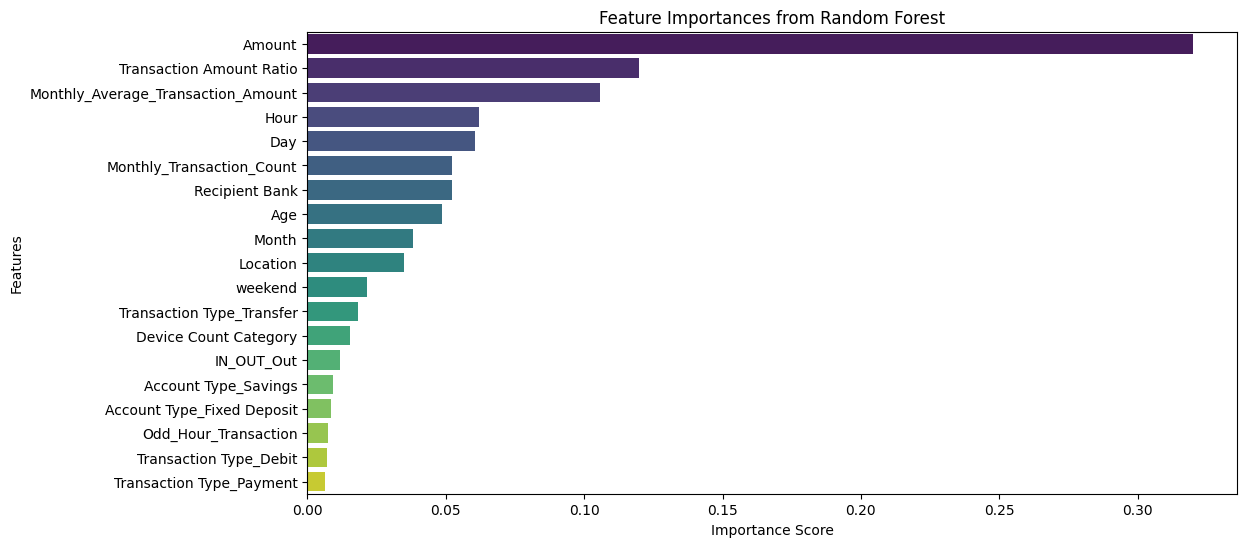

In [15]:
# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importances_df, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

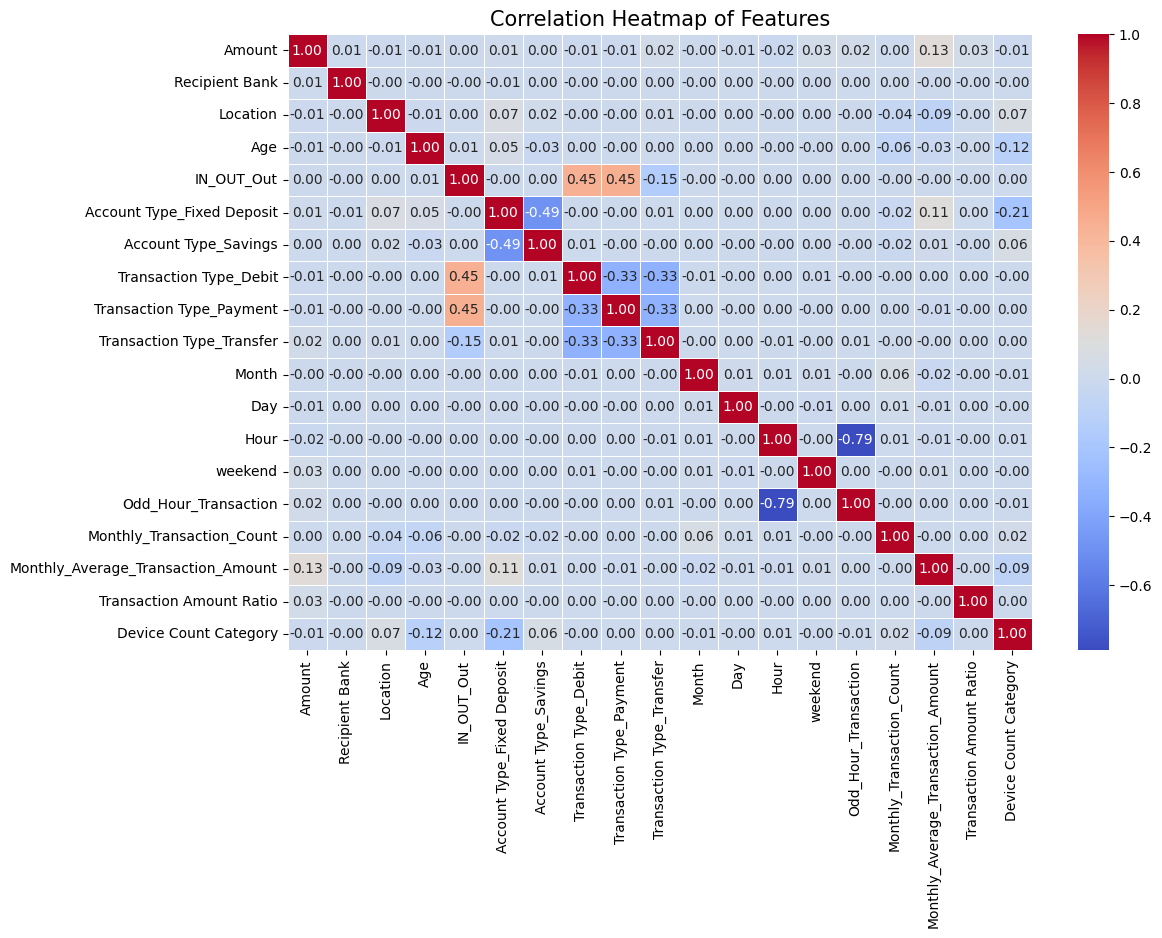

In [16]:
correlation_matrix = X_train.corr()


plt.figure(figsize=(12, 8))

# Draw the heatmap with seaborn
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)

# Add title to the heatmap
plt.title("Correlation Heatmap of Features", fontsize=15)

# Show the heatmap
plt.show()

In [19]:
rf2 = RandomForestClassifier(random_state=42)

#Cross Validation
k = 5  # Number of folds
cv_scores = cross_val_score(rf2, X_train, y_train, cv=k, scoring='f1')

print(f"Cross-Validation F1 Scores: {cv_scores}")
print(f"Mean F1 Score: {cv_scores.mean()}")


rf2.fit(X_train, y_train)

y_pred = rf2.predict(X_test)

print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred))

Cross-Validation F1 Scores: [0.43774319 0.49863512 0.48926237 0.52126697 0.4953271 ]
Mean F1 Score: 0.4884469512490533
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     19033
           1       0.89      0.31      0.46       967

    accuracy                           0.96     20000
   macro avg       0.93      0.65      0.72     20000
weighted avg       0.96      0.96      0.96     20000



After Feature Selection

In [17]:
# Select the top 10 most important features
top_features = feature_importances_df.nlargest(10, 'Importance')['Feature']

#Trainingset with only top 10 features
X_train_top = X_train[top_features]


print("Top 10 Features:")
print(top_features)

Top 10 Features:
0                                 Amount
17              Transaction Amount Ratio
16    Monthly_Average_Transaction_Amount
12                                  Hour
11                                   Day
15             Monthly_Transaction_Count
1                         Recipient Bank
3                                    Age
10                                 Month
2                               Location
Name: Feature, dtype: object


In [27]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr.fit(X_train, y_train)


y_pred = lr.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[17143  1952]
 [  489   516]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93     19095
           1       0.21      0.51      0.30      1005

    accuracy                           0.88     20100
   macro avg       0.59      0.71      0.62     20100
weighted avg       0.93      0.88      0.90     20100

ROC-AUC Score: 0.8203


With Hyperparameter Tuning

In [20]:
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

#Models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, scale_pos_weight=13, max_depth=15,
                             learning_rate=0.05, n_estimators=3000, reg_lambda=3,
                             reg_alpha=3, random_state=42, eval_metric='logloss'),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
}

# Train and evaluate models
for model_name, model in models.items():
    # Perform cross-validation on the training set
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    print(f"{model_name} Cross-Validation F1 Scores: {cv_scores}")
    print(f"{model_name} Mean F1 Score: {cv_scores.mean()}\n")

    # Fit the model on the full training set
    model.fit(X_train, y_train)

    # Predict on the validation set
    y_val_pred = model.predict(X_val)
    print(f"{model_name} Classification Report on Validation Set:")
    print(classification_report(y_val, y_val_pred))

    # Confusion matrix for the validation set
    conf_matrix_val = confusion_matrix(y_val, y_val_pred)
    print(f"{model_name} Confusion Matrix on Validation Set:")
    print(conf_matrix_val)

    # Calculate ROC-AUC for the validation set
    y_val_proba = model.predict_proba(X_val)[:, 1]
    roc_auc_val = roc_auc_score(y_val, y_val_proba)
    print(f"{model_name} ROC-AUC Score on Validation Set: {roc_auc_val:.4f}")

    # Test Set Predictions
    y_test_pred = model.predict(X_test)
    print(f"{model_name} Classification Report on Test Set:")
    print(classification_report(y_test, y_test_pred))

    # Confusion matrix for the test set
    conf_matrix_test = confusion_matrix(y_test, y_test_pred)
    print(f"{model_name} Confusion Matrix on Test Set:")
    print(conf_matrix_test)

    # Calculate ROC-AUC for the test set
    y_test_proba = model.predict_proba(X_test)[:, 1]
    roc_auc_test = roc_auc_score(y_test, y_test_proba)
    print(f"{model_name} ROC-AUC Score on Test Set: {roc_auc_test:.4f}")

    print("\n" + "="*60 + "\n")


Random Forest Cross-Validation F1 Scores: [0.45027322 0.46956522 0.49081081 0.47741935 0.49737671]
Random Forest Mean F1 Score: 0.4770890624452398

Random Forest Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      9515
           1       0.89      0.34      0.49       485

    accuracy                           0.97     10000
   macro avg       0.93      0.67      0.74     10000
weighted avg       0.96      0.97      0.96     10000

Random Forest Confusion Matrix on Validation Set:
[[9495   20]
 [ 321  164]]
Random Forest ROC-AUC Score on Validation Set: 0.9253
Random Forest Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     19029
           1       0.89      0.34      0.49       971

    accuracy                           0.97     20000
   macro avg       0.93      0.67      0.74     20000
weighted avg      

CNN MODEL

In [10]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape input data to be 3D for Conv1D
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = Sequential()

#Conv layer 1
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

#Conv layer 2
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

#Conv Layer 3
model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(BatchNormalization())



model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

#Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)


history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Model evaluation
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.9540 - loss: 0.5956 - val_accuracy: 0.9632 - val_loss: 0.1424
Epoch 2/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 32s 29ms/step - accuracy: 0.9631 - loss: 0.1423 - val_accuracy: 0.9633 - val_loss: 0.1365
Epoch 3/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.9626 - loss: 0.1346 - val_accuracy: 0.9628 - val_loss: 0.1326
Epoch 4/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 29s 14ms/step - accuracy: 0.9630 - loss: 0.1307 - val_accuracy: 0.9636 - val_loss: 0.1223
Epoch 5/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9630 - loss: 0.1262 - val_accuracy: 0.9644 - val_loss: 0.1216
Epoch 6/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.9636 - loss: 0.1232 - val_accuracy: 0.9635 - val_loss: 0.1245
Epoch 7/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9645 - loss: 0.1195 - val_accuracy: 0.9640 - val_loss: 0.1232
Epoch 8/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.9643 -

In [12]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Confusion Matrix:
[[18843   186]
 [  551   420]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     19029
           1       0.69      0.43      0.53       971

    accuracy                           0.96     20000
   macro avg       0.83      0.71      0.76     20000
weighted avg       0.96      0.96      0.96     20000



In [13]:
X_val = scaler.transform(X_val)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)



In [14]:
y_pred_val = (model.predict(X_val) > 0.5).astype("int32")
# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred_val)
print("Confusion Matrix on Validation Set:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_val, y_pred_val)
print("Classification Report on Validation Set:")
print(class_report)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Confusion Matrix on Validation Set:
[[9409  106]
 [ 277  208]]
Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      9515
           1       0.66      0.43      0.52       485

    accuracy                           0.96     10000
   macro avg       0.82      0.71      0.75     10000
weighted avg       0.96      0.96      0.96     10000



LSTM

In [31]:
import torch
import torch.nn as nn



In [33]:
# If X_train is 3D, reshape it to 2D
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)


# Apply scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)
X_val_scaled = scaler.transform(X_val_reshaped)


In [34]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

In [35]:
X_train_lstm = X_train_tensor.view(X_train_tensor.size(0), 1, X_train_tensor.size(1))
X_test_lstm = X_test_tensor.view(X_test_tensor.size(0), 1, X_test_tensor.size(1))
X_val_lstm = X_val_tensor.view(X_val_tensor.size(0), 1, X_val_tensor.size(1))

In [36]:
class LSTMModel(nn.Module):
    def __init__(self, input_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, 64, batch_first=True)  # 64 hidden units
        self.fc = nn.Linear(64, 1)  # Output layer for binary classification

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = self.fc(hn[-1])  # Take the last hidden state
        return torch.sigmoid(out)  # Output probabilities

In [37]:
model = LSTMModel(input_size=X_train_tensor.size(1))  # Input size matches the number of features
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [38]:
model.train()
num_epochs = 30

for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(X_train_lstm)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training complete!")

Epoch [10/30], Loss: 0.7016
Epoch [20/30], Loss: 0.6724
Epoch [30/30], Loss: 0.6409
Training complete!


In [39]:
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test_lstm)
    y_pred_class = (y_pred_prob > 0.5).float()

    y_pred_class_np = y_pred_class.numpy()
    y_test_np = y_test_tensor.numpy()


    conf_matrix = confusion_matrix(y_test_np, y_pred_class_np)
    class_report = classification_report(y_test_np, y_pred_class_np)

    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)

Confusion Matrix:
[[17535  1560]
 [  634   371]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.92      0.94     19095
         1.0       0.19      0.37      0.25      1005

    accuracy                           0.89     20100
   macro avg       0.58      0.64      0.60     20100
weighted avg       0.93      0.89      0.91     20100



Model Aggregation

In [ ]:
!pip install tensorflow


In [41]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

In [42]:
X_train_ens, X_test_ens, y_train_ens, y_test_ens = train_test_split(X, y, test_size=0.2, random_state=42)


In [43]:
scaler = StandardScaler()
X_train_cnn = scaler.fit_transform(X_train_ens)
X_test_cnn = scaler.transform(X_test_ens)

# Reshape for Conv1D (CNN expects 3D input)
X_train_cnn = X_train_cnn.reshape(X_train_cnn.shape[0], X_train_cnn.shape[1], 1)
X_test_cnn = X_test_cnn.reshape(X_test_cnn.shape[0], X_test_cnn.shape[1], 1)

# CNN model
cnn_model = Sequential()

# Conv1D layers
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling1D(pool_size=2))

cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling1D(pool_size=2))

cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.4))
cnn_model.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the CNN
cnn_model.fit(X_train_cnn, y_train_ens, epochs=20, batch_size=64, validation_data=(X_test_cnn, y_test_ens), callbacks=[early_stopping])

# Get predicted probabilities for CNN
cnn_probs = cnn_model.predict(X_test_cnn)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.9532 - loss: 0.1780 - val_accuracy: 0.9628 - val_loss: 0.1245
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9625 - loss: 0.1297 - val_accuracy: 0.9631 - val_loss: 0.1213
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9630 - loss: 0.1233 - val_accuracy: 0.9639 - val_loss: 0.1180
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9638 - loss: 0.1167 - val_accuracy: 0.9640 - val_loss: 0.1183
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9651 - loss: 0.1111 - val_accuracy: 0.9633 - val_loss: 0.1151
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.9645 - loss: 0.1123 - val_accuracy: 0.9637 - val_loss: 0.1131
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - accuracy: 0.9660 - loss: 0.1063 - val_accuracy: 0.9640 - val_loss: 0.1087
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.9650 -

In [44]:
logistic_regression = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    C=0.01,
    class_weight={0: 1, 1: 10},
    random_state=42,
    max_iter=1000
)
random_forest = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        random_state=42
    )
xgboost = XGBClassifier(use_label_encoder=False, scale_pos_weight=13,max_depth=15,learning_rate=0.05,n_estimators=3000,reg_lambda=3, reg_alpha=3,
    random_state=42,
    eval_metric=['logloss', 'auc'])

adaboost = AdaBoostClassifier(
        n_estimators=100,
        learning_rate=0.05,
        random_state=42
    )

# Fit traditional models
logistic_regression.fit(X_train_ens, y_train_ens)
random_forest.fit(X_train_ens, y_train_ens)
xgboost.fit(X_train_ens, y_train_ens)
adaboost.fit(X_train_ens, y_train_ens)

AdaBoostClassifier(learning_rate=0.05, n_estimators=100, random_state=42)

In [45]:
y_pred_logistic = logistic_regression.predict(X_test_ens)
y_pred_rf = random_forest.predict(X_test_ens)
y_pred_xgb = xgboost.predict(X_test_ens)
y_pred_ada = adaboost.predict(X_test_ens)

In [46]:
y_pred_probs_rf = random_forest.predict_proba(X_test_ens)[:, 1]
y_pred_probs_xgb = xgboost.predict_proba(X_test_ens)[:, 1]
y_pred_probs_ada = adaboost.predict_proba(X_test_ens)[:, 1]
y_pred_probs_logistic = logistic_regression.predict_proba(X_test_ens)[:, 1]

In [47]:
cnn_preds_binary = (cnn_probs > 0.5).astype(int).flatten()  # Ensure it is 1D

# Majority Voting
predictions_majority = np.array([y_pred_logistic, y_pred_rf, y_pred_xgb, y_pred_ada, cnn_preds_binary])
y_pred_majority = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions_majority)

In [48]:

# Soft Voting
predictions_soft = np.array([y_pred_probs_logistic, y_pred_probs_rf, y_pred_probs_xgb, y_pred_probs_ada, cnn_probs.flatten()])
y_pred_soft = (predictions_soft.mean(axis=0) > 0.5).astype(int)

In [49]:

print("Majority Voting Ensemble")
print("Confusion Matrix:")
print(confusion_matrix(y_test_ens, y_pred_majority))
print("Classification Report:")
print(classification_report(y_test_ens, y_pred_majority))

print("\nSoft Voting Ensemble")
print("Confusion Matrix:")
print(confusion_matrix(y_test_ens, y_pred_soft))
print("Classification Report:")
print(classification_report(y_test_ens, y_pred_soft))

Majority Voting Ensemble
Confusion Matrix:
[[19014    19]
 [  690   277]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     19033
           1       0.94      0.29      0.44       967

    accuracy                           0.96     20000
   macro avg       0.95      0.64      0.71     20000
weighted avg       0.96      0.96      0.96     20000


Soft Voting Ensemble
Confusion Matrix:
[[18973    60]
 [  632   335]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     19033
           1       0.85      0.35      0.49       967

    accuracy                           0.97     20000
   macro avg       0.91      0.67      0.74     20000
weighted avg       0.96      0.97      0.96     20000



In [51]:
#Selected Models
# Soft Voting
predictions_soft = np.array([y_pred_probs_logistic, y_pred_probs_xgb, cnn_probs.flatten()])
y_pred_soft = (predictions_soft.mean(axis=0) > 0.5).astype(int)
# Majority Voting
predictions_majority = np.array([y_pred_logistic, y_pred_xgb,  cnn_preds_binary])
y_pred_majority = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions_majority)

In [62]:

print("Majority Voting Ensemble")
print("Confusion Matrix:")
print(confusion_matrix(y_test_ens, y_pred_majority))
print("Classification Report:")
print(classification_report(y_test_ens, y_pred_majority))

print("\nSoft Voting Ensemble")
print("Confusion Matrix:")
print(confusion_matrix(y_test_ens, y_pred_soft))
print("Classification Report:")
print(classification_report(y_test_ens, y_pred_soft))

print("Majority Voting ROC")
print( roc_auc_score(y_test_ens, y_pred_majority))
print("Soft Voting ROC")
print( roc_auc_score(y_test_ens, y_pred_soft))

Majority Voting Ensemble
Confusion Matrix:
[[18888   145]
 [  582   385]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     19033
           1       0.73      0.40      0.51       967

    accuracy                           0.96     20000
   macro avg       0.85      0.70      0.75     20000
weighted avg       0.96      0.96      0.96     20000


Soft Voting Ensemble
Confusion Matrix:
[[18890   143]
 [  552   415]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     19033
           1       0.74      0.43      0.54       967

    accuracy                           0.97     20000
   macro avg       0.86      0.71      0.76     20000
weighted avg       0.96      0.97      0.96     20000

Majority Voting ROC
0.6952601129122548
Soft Voting ROC
0.710824545687833
